1. DATA PREPROCESSING

In [ ]:
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors

try:
    spark.stop()
    print("Old spark session stopped")
except:
    print("Continue")

spark = (SparkSession.builder
         .appName("Movies Analytics")
         .master("local[*]")
         .config("spark.hadoop.fs.defaultFS","hdfs://namenode:9000")
         .getOrCreate())

Continue


In [2]:
HDFS_PATH = "hdfs://namenode:9000/movie_dataset/movies_1m.csv"

schema = T.StructType([
    T.StructField("id", T.StringType(), True),
    T.StructField("title", T.StringType(), True),
    T.StructField("vote_average", T.DoubleType(), True),
    T.StructField("vote_count", T.DoubleType(), True),
    T.StructField("status", T.StringType(), True),
    T.StructField("release_date", T.StringType(), True),
    T.StructField("revenue", T.DoubleType(), True),
    T.StructField("runtime", T.DoubleType(), True),
    T.StructField("adult", T.StringType(), True),
    T.StructField("backdrop_path", T.StringType(), True),
    T.StructField("budget", T.DoubleType(), True),
    T.StructField("homepage", T.StringType(), True),
    T.StructField("imdb_id", T.StringType(), True),
    T.StructField("original_language", T.StringType(), True),
    T.StructField("original_title", T.StringType(), True),
    T.StructField("overview", T.StringType(), True),
    T.StructField("popularity", T.DoubleType(), True),
    T.StructField("poster_path", T.StringType(), True),
    T.StructField("tagline", T.StringType(), True),
    T.StructField("production_companies", T.StringType(), True),
    T.StructField("production_countries", T.StringType(), True),
    T.StructField("spoken_languages", T.StringType(), True),
    T.StructField("keywords", T.StringType(), True),
    T.StructField("release_year", T.DoubleType(), True),
    T.StructField("Director", T.StringType(), True),
    T.StructField("AverageRating", T.DoubleType(), True),
    T.StructField("Poster_Link", T.StringType(), True),
    T.StructField("Certificate", T.StringType(), True),
    T.StructField("IMDB_Rating", T.DoubleType(), True),
    T.StructField("Meta_score", T.DoubleType(), True),
    T.StructField("Star1", T.StringType(), True),
    T.StructField("Star2", T.StringType(), True),
    T.StructField("Star3", T.StringType(), True),
    T.StructField("Star4", T.StringType(), True),
    T.StructField("Writer", T.StringType(), True),
    T.StructField("Director_of_Photography", T.StringType(), True),
    T.StructField("Producers", T.StringType(), True),
    T.StructField("Music_Composer", T.StringType(), True),
    T.StructField("genres_list", T.StringType(), True),
    T.StructField("Cast_list", T.StringType(), True),
    T.StructField("overview_sentiment", T.DoubleType(), True),
    T.StructField("all_combined_keywords", T.StringType(), True)
])

#Load with fixed scheme
df = (spark.read
    .format("csv")
    .schema(schema)
    .option("header", True)
    .option("multiLine", True)
    .option("quote", '"')
    .option("escape", '"')
    .option("ignoreLeadingWhiteSpace", True)
    .option("ignoreTrailingWhiteSpace", True)
    .option("mode", "PERMISSIVE")
    .load(HDFS_PATH)
    .cache())

ROW_CT = df.count()
print("Total rows:", ROW_CT)
print("Total columns:", len(df.columns))
df.select("title","release_year","budget","revenue","runtime","AverageRating","IMDB_Rating","Meta_score","Director").show(5, truncate=False)


Total rows: 1072255
Total columns: 42
+---------------+------------+------+-------------+-------+-------------+-----------+----------+-----------------+
|title          |release_year|budget|revenue      |runtime|AverageRating|IMDB_Rating|Meta_score|Director         |
+---------------+------------+------+-------------+-------+-------------+-----------+----------+-----------------+
|Inception      |2010.0      |1.6E8 |8.25532764E8 |148.0  |8.8          |8.8        |74.0      |Christopher Nolan|
|Interstellar   |2014.0      |1.65E8|7.01729206E8 |169.0  |8.7          |8.6        |74.0      |Christopher Nolan|
|The Dark Knight|2008.0      |1.85E8|1.004558444E9|152.0  |9.0          |9.0        |84.0      |Christopher Nolan|
|Avatar         |2009.0      |2.37E8|2.923706026E9|162.0  |7.9          |7.8        |83.0      |James Cameron    |
|The Avengers   |2012.0      |2.2E8 |1.518815515E9|143.0  |8.0          |8.0        |69.0      |Joss Whedon      |
+---------------+------------+------+-----

In [3]:
# Column type, categorized the type for further operation
dtype_map = dict(df.dtypes)
num_types = {"double","float","int","bigint","long","decimal","smallint","tinyint"}
num_cols = [c for c,t in df.dtypes if t in num_types]
cat_cols = [c for c,t in df.dtypes if t not in num_types]

# null count
agg_null_exprs = []
for c in df.columns:
    if dtype_map[c] in num_types:
        agg_null_exprs.append(F.sum(F.when(F.isnan(F.col(c)) | F.col(c).isNull(), 1).otherwise(0)).alias(c))
    else:
        agg_null_exprs.append(F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c))

null_counts = df.agg(*agg_null_exprs).collect()[0].asDict()

# Distinct count
distinct_exprs = [F.countDistinct(F.col(c)).alias(c) for c in df.columns]
distinct_counts = df.agg(*distinct_exprs).collect()[0].asDict()


rows = []
for c in df.columns:
    n_null = int(null_counts[c])
    pct_null = (n_null / ROW_CT) * 100 if ROW_CT else 0.0
    rows.append((c, dtype_map[c], ROW_CT, ROW_CT - n_null, n_null, pct_null, int(distinct_counts[c])))

summary_schema = T.StructType([
    T.StructField("column", T.StringType(), False),
    T.StructField("dtype", T.StringType(), False),
    T.StructField("rows_total", T.LongType(), False),
    T.StructField("rows_non_null", T.LongType(), False),
    T.StructField("rows_null", T.LongType(), False),
    T.StructField("pct_null", T.DoubleType(), False),
    T.StructField("distinct_count", T.LongType(), False),
])

null_summary = spark.createDataFrame(rows, schema=summary_schema)
null_summary.orderBy(F.desc("pct_null")).show(50, truncate=False)


+-----------------------+------+----------+-------------+---------+--------------------+--------------+
|column                 |dtype |rows_total|rows_non_null|rows_null|pct_null            |distinct_count|
+-----------------------+------+----------+-------------+---------+--------------------+--------------+
|Meta_score             |double|1072255   |2331         |1069924  |99.78260768194133   |61            |
|Star4                  |string|1072255   |2770         |1069485  |99.74166592834727   |740           |
|Poster_Link            |string|1072255   |2770         |1069485  |99.74166592834727   |788           |
|Star3                  |string|1072255   |2770         |1069485  |99.74166592834727   |692           |
|Star2                  |string|1072255   |2770         |1069485  |99.74166592834727   |650           |
|AverageRating          |double|1072255   |11751        |1060504  |98.90408531552663   |68            |
|Certificate            |string|1072255   |29835        |1042420

In [4]:
# Drop unused columns and columns with null > 80%
drop_list = [
    "Meta_score", "AverageRating", "IMDB_Rating", "Certificate",
    "Star1", "Star2", "Star3", "Star4",
    "Poster_Link", "homepage", "tagline", "Music_Composer",
    "backdrop_path", "Director_of_Photography", "Producers",
    "production_companies", "poster_path", "id"
]
cg = df.drop(*[c for c in df.columns if c in drop_list])
cg = df.cache()


print("Total columns:", len(cg.columns))

Total columns: 42


In [5]:
#Clean data

# change realease_date data type to date type
if "release_date" in cg.columns:
    cg = cg.withColumn("release_date", F.to_date("release_date", "yyyy-MM-dd"))

# filter data
cg = cg.filter((F.col("budget") >= 0) & (F.col("revenue") >= 0) & 
               (F.col("runtime") > 0) & (F.col("runtime") <= 400) &
               (F.col("release_year") >= 1900))

# add new features for modelling
cg = (cg
      .withColumn("log_budget", F.log1p("budget"))
      .withColumn("log_revenue", F.log1p("revenue"))
      .withColumn("profit_ratio", 
                  F.when(F.col("budget") > 0, F.col("revenue") / F.col("budget"))
                   .otherwise(None))
      .withColumn("is_hit", 
                  F.when(F.col("revenue") >= 2 * F.col("budget"), 1).otherwise(0))
     )



2. EXPLORATORY DATA ANALYSIS (EDA)

In [25]:
#Logistic Regression for Hit Movie Prediction


# Select numeric features and target column
features = ["budget", "revenue", "runtime", "vote_average", "vote_count", "popularity", "overview_sentiment"]

# Drop missing values to avoid model errors
ml_df = cg.select(*features, "is_hit").dropna()

# Combine all features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")
ml_df = assembler.transform(ml_df)

# Split data into training and test sets (80/20)
train_df, test_df = ml_df.randomSplit([0.8, 0.2], seed=42)

# Build logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="is_hit")
model = lr.fit(train_df)

# Make predictions on test data
pred = model.transform(test_df)

# Evaluate model performance using AUC
evaluator = BinaryClassificationEvaluator(labelCol="is_hit", metricName="areaUnderROC")
auc = evaluator.evaluate(pred)
print(f"AUC on test data: {auc:.4f}")

# Evaluate based on accuracy and F1 score

acc_eval = MulticlassClassificationEvaluator(labelCol="is_hit", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="is_hit", metricName="f1")

print("Accuracy:", acc_eval.evaluate(pred))
print("F1 Score:", f1_eval.evaluate(pred))

AUC on test data: 0.9823
Accuracy: 0.9940988991106595
F1 Score: 0.9939146423084904


2.1 Correlation Analysis

In [6]:
#Correlation analysis
num_cols = ["budget","revenue","runtime","vote_average","vote_count","popularity"]
corr = {f"{c1}-{c2}": cg.stat.corr(c1, c2)
        for i,c1 in enumerate(num_cols) for c2 in num_cols[i+1:]}
threshold = 0.2  

filtered_corr = {k: v for k, v in corr.items() if abs(v) >= threshold}

filtered_corr = dict(sorted(filtered_corr.items(), key=lambda x: abs(x[1]), reverse=True))

print("Most significant correlation:")
for k, v in filtered_corr.items():
    print(f"{k:25s}: {v:.4f}")


Most significant correlation:
revenue-vote_count       : 0.7445
budget-revenue           : 0.7378
budget-vote_count        : 0.6398
budget-popularity        : 0.2687
vote_count-popularity    : 0.2532
revenue-popularity       : 0.2424
runtime-vote_average     : 0.2150


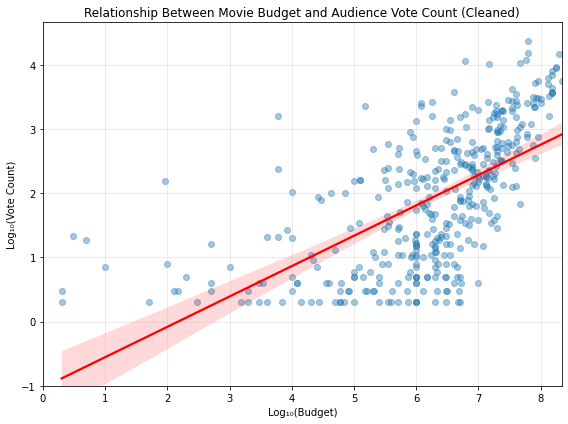

In [29]:
# Clean data before log-transform
budget_votes = (cg
    .filter((F.col("budget") > 1) & (F.col("vote_count") > 1))   # ensure >1 to avoid log(0)
    .select("budget", "vote_count")
    .dropna()
    .sample(False, 0.02, seed=42)
    .toPandas())

budget_votes["log_budget"] = np.log10(budget_votes["budget"])
budget_votes["log_votes"] = np.log10(budget_votes["vote_count"])

plt.figure(figsize=(8,6))
sns.regplot(x="log_budget", y="log_votes", data=budget_votes,
            scatter_kws={"alpha":0.4}, line_kws={"color":"red"})
plt.xlim(left=0)   # force start at 0
plt.ylim(bottom=-1)
plt.title("Relationship Between Movie Budget and Audience Vote Count (Cleaned)")
plt.xlabel("Log₁₀(Budget)")
plt.ylabel("Log₁₀(Vote Count)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The scatter plot shows a strong positive correlation between a movie’s budget and its vote count. As production budgets increase, the number of audience votes tends to rise as well. This indicates that higher-budget movies usually attract larger audiences, likely due to wider releases, stronger marketing, and better production quality. However, the spread of points suggests diminishing returns at very high budgets, meaning that while more money helps visibility, it doesn’t always guarantee proportionally higher engagement.

2.2 Feature Importance Analysis (Hit Movie Prediction)

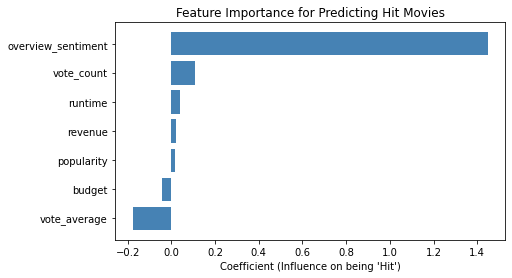

In [11]:
importance = pd.DataFrame({
    "feature": features,
    "coefficient": model.coefficients
}).sort_values("coefficient", ascending=False)

# Plot feature importance
plt.figure(figsize=(7,4))
plt.barh(importance["feature"], importance["coefficient"], color="steelblue")
plt.gca().invert_yaxis()
plt.title("Feature Importance for Predicting Hit Movies")
plt.xlabel("Coefficient (Influence on being 'Hit')")
plt.show()

This analysis identifies which features most strongly influence whether a movie becomes a “hit.” The logistic regression model shows that overview_sentiment has the largest positive impact, meaning films with more positive descriptions tend to perform better. Meanwhile, vote_count and revenue also contribute moderately, suggesting audience engagement and box office returns are important success indicators. Features like vote_average and budget have minimal or negative influence, indicating that high budgets or ratings alone do not guarantee a movie’s success.

2.3 Analysis of Genre Insights: Profitability and Audience Evolution

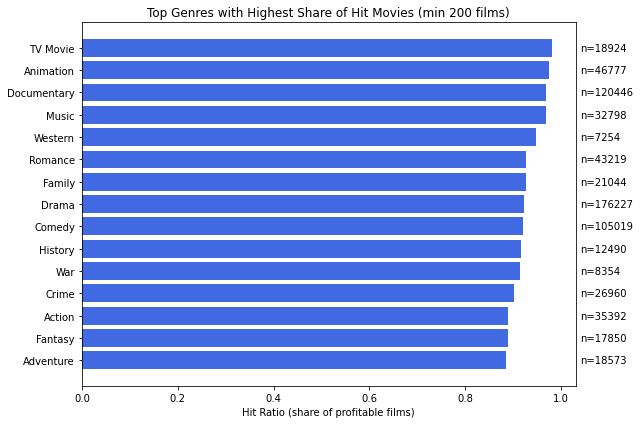

In [14]:
# Analyze which genres have the highest ratio of hit movies (profitable films)

g_hit = (cg_g.groupBy("genre")
          .agg(
              F.mean("is_hit").alias("hit_ratio"),   # proportion of hit films
              F.count("*").alias("film_count")
          )
          .filter((F.col("film_count") >= 200) & (F.col("genre") != "Unknown"))  # remove rare/outlier genres
          .orderBy(F.desc("hit_ratio"))
          .limit(15)
          .toPandas())

# Plot hit ratio per genre
plt.figure(figsize=(9,6))
plt.barh(g_hit["genre"], g_hit["hit_ratio"], color="royalblue")
plt.gca().invert_yaxis()
plt.xlabel("Hit Ratio (share of profitable films)")
plt.title("Top Genres with Highest Share of Hit Movies (min 200 films)")
for i, v in enumerate(g_hit["film_count"]):
    plt.text(1.01, i, f"n={v}", transform=plt.gca().get_yaxis_transform(), va="center")
plt.tight_layout()
plt.show()


The analysis reveals that TV Movie, Animation, and Documentary genres have the highest Hit Ratios, meaning these genres most frequently generate revenues at least twice their production budgets.

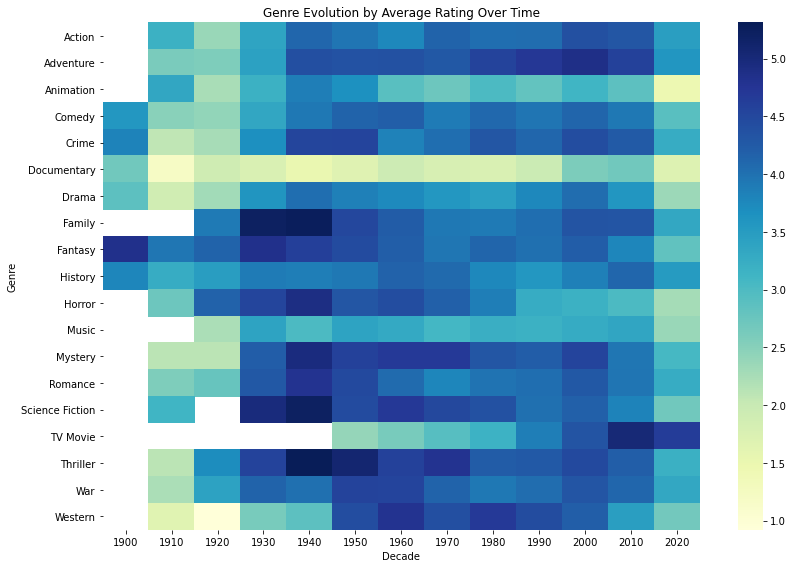

In [16]:
# Genre Evolution Over time

# Extract individual genres
# convert string like "['Action','Drama']" -> array ['Action','Drama']
genres_arr = F.split(F.regexp_replace(F.col("genres_list"), r"[\[\]']", ""), r"\s*,\s*")
cg_g = cg.withColumn("genre", F.explode(genres_arr)).withColumn("genre", F.trim(F.col("genre")))

# remove empty or 'Unknown' genre
cg_g = cg_g.filter((F.col("genre") != "") & (F.col("genre") != "Unknown"))

# Create decade column
cg_g = cg_g.withColumn("decade", (F.floor(F.col("release_year") / 10) * 10).cast("int"))

# Aggregate per genre per decade
genre_trend = (
    cg_g.groupBy("decade", "genre")
        .agg(
            F.count("*").alias("film_count"),
            F.mean("vote_average").alias("avg_rating"),
            F.mean("is_hit").alias("hit_ratio")
        )
        .filter(F.col("film_count") > 50)  # filter only genres with enough films
        .toPandas()
)

# Pivot for heatmap
pivot = genre_trend.pivot_table(
    index="genre",
    columns="decade",
    values="avg_rating",  # you can switch to 'hit_ratio' for profitability view
    aggfunc="mean"
)

# Plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="YlGnBu", annot=False)
plt.title("Genre Evolution by Average Rating Over Time")
plt.xlabel("Decade")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


This chart explores how audience preferences for each movie genre have changed over time. The heatmap shows that Drama, Fantasy, and War genres received the highest ratings during the mid-20th century, while Science Fiction and Thriller genres became increasingly popular from the 1980s onwards. In more recent decades, the differences between genres have narrowed, suggesting that audiences are now more evenly distributed across genres. This shift highlights how changing trends, technology, and storytelling styles influence which genres resonate most with viewers.

2.4 Relationship Analysis Between Movie Budget and Audience Rating

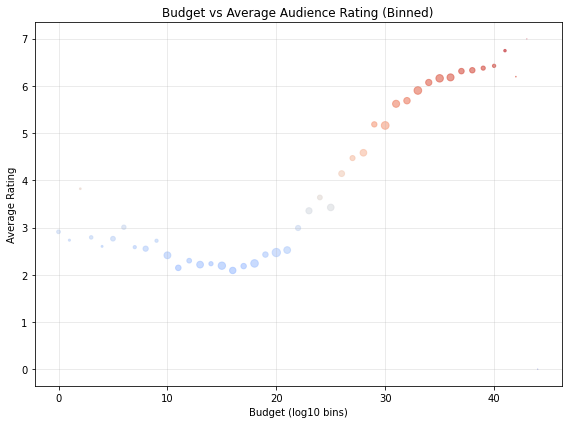

In [18]:
# Budget vs Average Rating

# Group by binned budget values for smoother plot
binned_rating = (cg
    .withColumn("budget_bin", (F.log10("budget")/0.2).cast("int"))
    .groupBy("budget_bin")
    .agg(F.mean("vote_average").alias("avg_rating"),
         F.count("*").alias("film_count"))
    .orderBy("budget_bin")
    .toPandas())

plt.figure(figsize=(8,6))
plt.scatter(binned_rating["budget_bin"], binned_rating["avg_rating"],
            s=binned_rating["film_count"]/30, alpha=0.6, c=binned_rating["avg_rating"], cmap="coolwarm")
plt.xlabel("Budget (log10 bins)")
plt.ylabel("Average Rating")
plt.title("Budget vs Average Audience Rating (Binned)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


This chart explores how a movie’s budget size relates to its average audience rating. From the visualisation, we can see a non-linear pattern, low-budget movies generally receive moderate ratings, while very high-budget films (large-scale productions) tend to achieve higher audience approval. However, there’s also a dip in the mid-range budgets, suggesting that medium-budget movies might struggle to stand out against both indie films (with strong storytelling) and blockbusters (with massive production value).